<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-нейросети" data-toc-modified-id="Обучение-нейросети-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение нейросети</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Код-модели" data-toc-modified-id="Код-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Код модели</a></span></li></ul></div>

# Исследовательский анализ данных

# Обработка фотографий покупателя

Построим для супермаркета "Хлеб-Соль" систему определения возраста покупателей с целью предложения им персонализированных товаров и услуг.
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей определенной системой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Для этого обучим нейросеть распознавать возраст покупателей по их фотографии.

## Исследовательский анализ данных

Импортируем необходимые для работы библиотеки.

In [1]:
#Импорт стандартных библиотек
import os
import pandas as pd
import matplotlib.pyplot as plt

# Импорт внешних библиотек
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Импортируем фотоматериалы для обучения нейросети. Разобъем датасет на train и test выборки.

**Train выборка**

In [6]:
#df_labels = pd.read_csv(os.path.join(path, 'labels.csv'))
df_labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25,
                                   vertical_flip=True,
                                   horizontal_flip=True)

train_data = train_datagen.flow_from_dataframe(
    df_labels,
    x_col='file_name',
    y_col='real_age',
    directory=os.path.join(path, 'final_files/'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=12345)

Found 0 validated image filenames.


/opt/conda/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 7591 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


**Test выборка**

In [8]:
#df_labels = pd.read_csv(os.path.join(path, 'labels.csv'))
df_labels = pd.read_csv('/datasets/faces/labels.csv')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.25)

test_data = test_datagen.flow_from_dataframe(
    df_labels,
    x_col='file_name',
    y_col='real_age',
    directory=os.path.join(path, 'final_files/'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=12345)

Found 0 validated image filenames.


Посмотрим на размер выборки.

In [9]:
features, target = next(train_data)

display(features.shape)

(0, 224, 224, 3)


Выборка состоит из 16 фотографий размерностью 224х224 пикселей, с тремя цветовыми каналами.

Построим график распределения возраста в выборке.

(array([237.,  25., 101.,  87., 135.,  44.,  34.,  45., 107.,  79., 125.,
        128., 356., 193., 180., 178., 322., 213., 211., 315., 226., 446.,
        164., 317., 129., 318., 156., 147., 122., 268., 107., 167.,  98.,
        184.,  96.,  88.,  74., 159.,  74., 156.,  70.,  76.,  89.,  51.,
         41.,  37.,  95.,  75.,  28.,  28.,  43.,  36.,  18.,  18.,  33.,
         50.,  10.,  13.,  16.,  17.,   7.,   8.,   3.,  37.,   3.,   5.,
          3.,  20.,   3.,   6.,   3.,  25.,   1.,   0.,   1.,   7.,   2.,
          1.,   0.,   1.]),
 array([  1.    ,   2.2375,   3.475 ,   4.7125,   5.95  ,   7.1875,
          8.425 ,   9.6625,  10.9   ,  12.1375,  13.375 ,  14.6125,
         15.85  ,  17.0875,  18.325 ,  19.5625,  20.8   ,  22.0375,
         23.275 ,  24.5125,  25.75  ,  26.9875,  28.225 ,  29.4625,
         30.7   ,  31.9375,  33.175 ,  34.4125,  35.65  ,  36.8875,
         38.125 ,  39.3625,  40.6   ,  41.8375,  43.075 ,  44.3125,
         45.55  ,  46.7875,  48.025 ,  49.2625

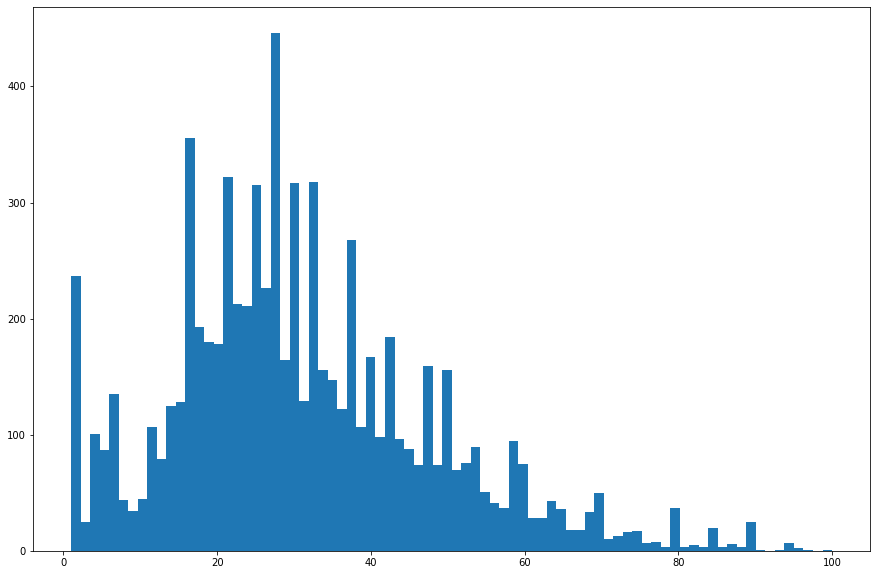

In [10]:
plt.figure(figsize=(15, 10))
plt.hist(df_labels['real_age'], bins=80)

Средний возраст людей на фотографии от 25 до 30 лет.

Сделаем принт фотографий, чтобы посмотреть как устроен датасет.

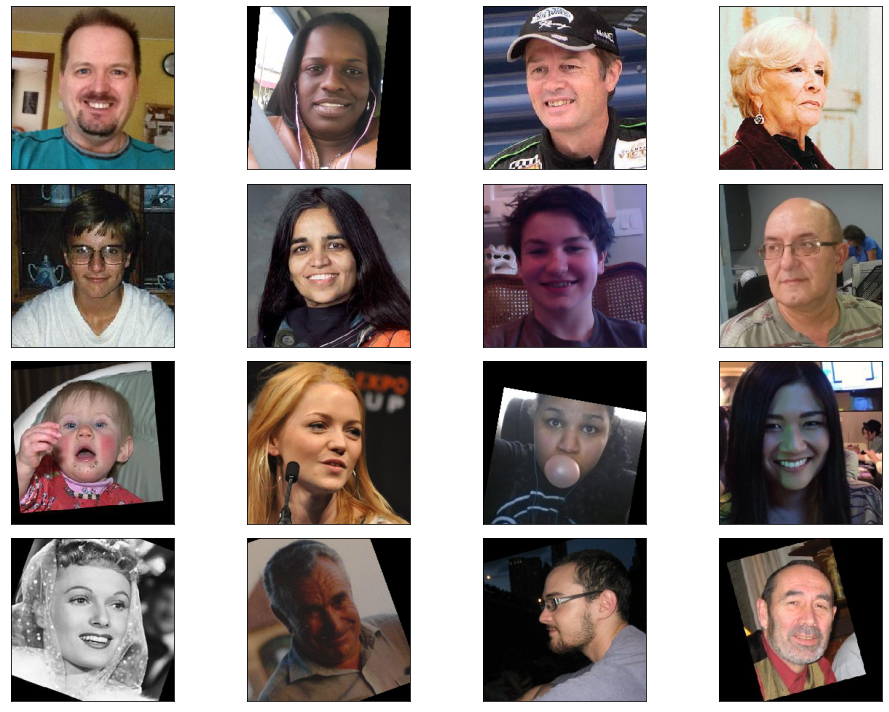

In [5]:
fig = plt.figure(figsize=(15, 10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Из обзора видно:
1. В датасете есть старые и черно-белые фотографии. Имеет смысл делать аугментацию с тем, чтобы делать фотографию черно-белой в некотором проценте случаев (нету в стандартном наборе). Возможно, стоит подкрутить цветовые каналы или яркость.
2. В датасете есть фотогарафи, на которых лица изображены под разными углами к вертикальной оси. Имеет смысл делать аугментацию с rotation_range равным +-15-20 градусов в некотором проценте случаев. Поворачивать можно как само изображение так и объект отдельно от фона.
3. В датасете есть фотогарафи, на которых лица изображены в полупрофиль. Имеет смысл делать аугментацию с отражением по горизонтали в некотором проценте случаев.
4. В датасете есть фотогарафи с разным разрешением. Имеет смысл делать аугментацию с изменением контрастности изображения в некотором проценте случаев.
5. В датасете есть фотогарафи, на которых изображены не лица, а голова и часть туловища (иногда человек послностью). Имеет смысл делать аугментацию с обезкой и масштабированием изображения в некотором проценте случаев, чтобы на фото были только лица примерно одного масштаба.

## Обучение нейросети

Создадим нейросеть ResNet с 50 слоями, предобученную на выборке *imagenet*.
Нейросет будет иметь следующе параметры:
* Оптимайзер выберем Adam с шагом градиентного спуска 0.0001.
* MAE в качестве метрики.
* MSE в качестве функции потерь.
* 5 эпох.
* 1 нейрон на выходе с активатором *relu*.

In [ ]:
optimizer = Adam(lr=0.0001)
backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='relu'))
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

Обучим нейросеть и посмотрим на среднюю квадратичную ошибку ее предсказаний.

In [ ]:
model.fit(train_data,
          validation_data=test_data,
          batch_size=None,
          epochs=5,
          steps_per_epoch=None,
          validation_steps=None,
          verbose=2,
          shuffle=True)

## Общий вывод

Мы обучили предобученную на другом датасете нейросеть ResNet с 50 слоями нейронов. Обучение происходило на фотографиях покупателей нашего магазина.

Для оценки модели мы использовали метрику MAE.

MAE итоговой модели оказалась равной 7.6184 на 5 эпохе.

Теперь мы можем использовать модель для предсказания возраста наших покупателей на кассе внедрив ее в соответствующую систему фотофиксации.

## Код модели